In [1]:
from pathlib import Path

import numpy as np

# import pysr before torch to avoid
# UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
import pysr  # noqa: F401
from zanj import ZANJ

from maze_dataset import LatticeMazeGenerators, MazeDataset, MazeDatasetConfig
from maze_dataset.benchmark.config_sweep import (
	SweepResult,
	dataset_success_fraction,
	full_percolation_analysis,
	plot_grouped,
)
from maze_dataset.benchmark.sweep_fit import sweep_fit

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


# run a basic analysis

tqdm_allowed_kwargs = {'mininterval', 'nrows', 'smoothing', 'ascii', 'unit_scale', 'position', 'self', 'gui', 'unit', 'leave', 'ncols', 'miniters', 'initial', 'write_bytes', 'colour', 'lock_args', 'desc', 'total', 'disable', 'file', 'postfix', 'bar_format', 'delay', 'maxinterval', 'iterable', 'unit_divisor', 'dynamic_ncols'}
mapped_kwargs = {'total': 3, 'desc': 'Processing 3 items'}


Processing 3 items: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


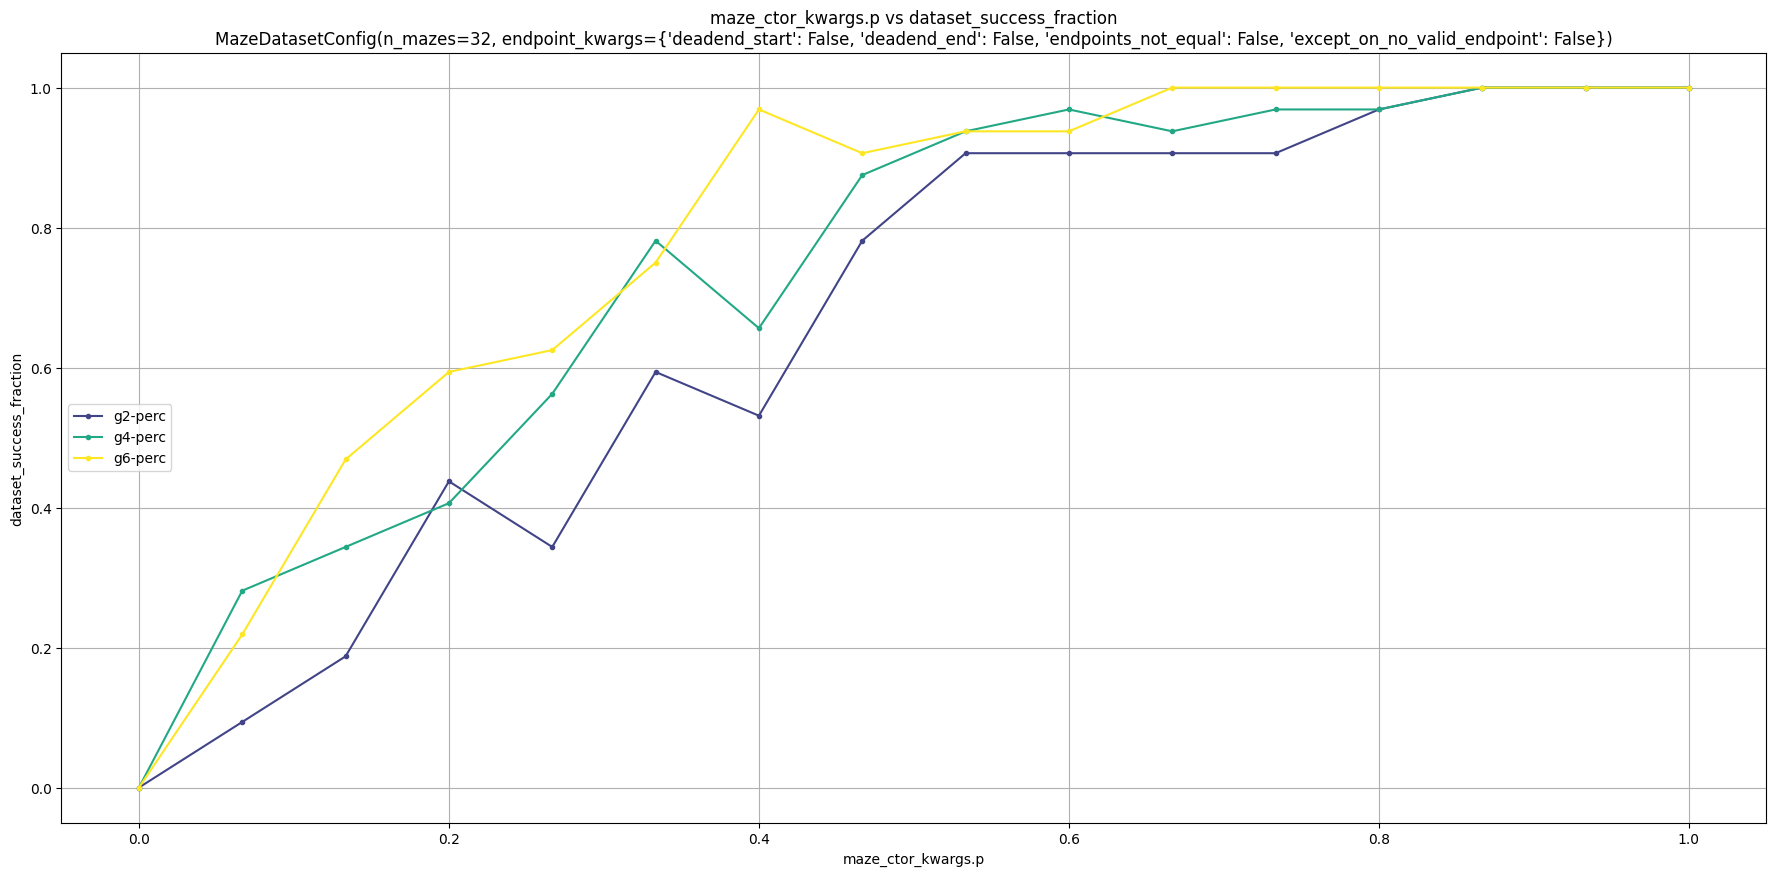

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [2]:
# Run the analysis
results: SweepResult = SweepResult.analyze(
	configs=[
		MazeDatasetConfig(
			name=f"g{grid_n}-perc",
			grid_n=grid_n,
			n_mazes=32,
			maze_ctor=LatticeMazeGenerators.gen_percolation,
			maze_ctor_kwargs=dict(),
			endpoint_kwargs=dict(
				deadend_start=False,
				deadend_end=False,
				endpoints_not_equal=False,
				except_on_no_valid_endpoint=False,
			),
		)
		for grid_n in [2, 4, 6]
	],
	param_values=np.linspace(0.0, 1.0, 16).tolist(),
	param_key="maze_ctor_kwargs.p",
	analyze_func=dataset_success_fraction,
	parallel=False,
)

# Plot results
results.plot(save_path=None, cfg_keys=["n_mazes", "endpoint_kwargs"])


## check saving/loading

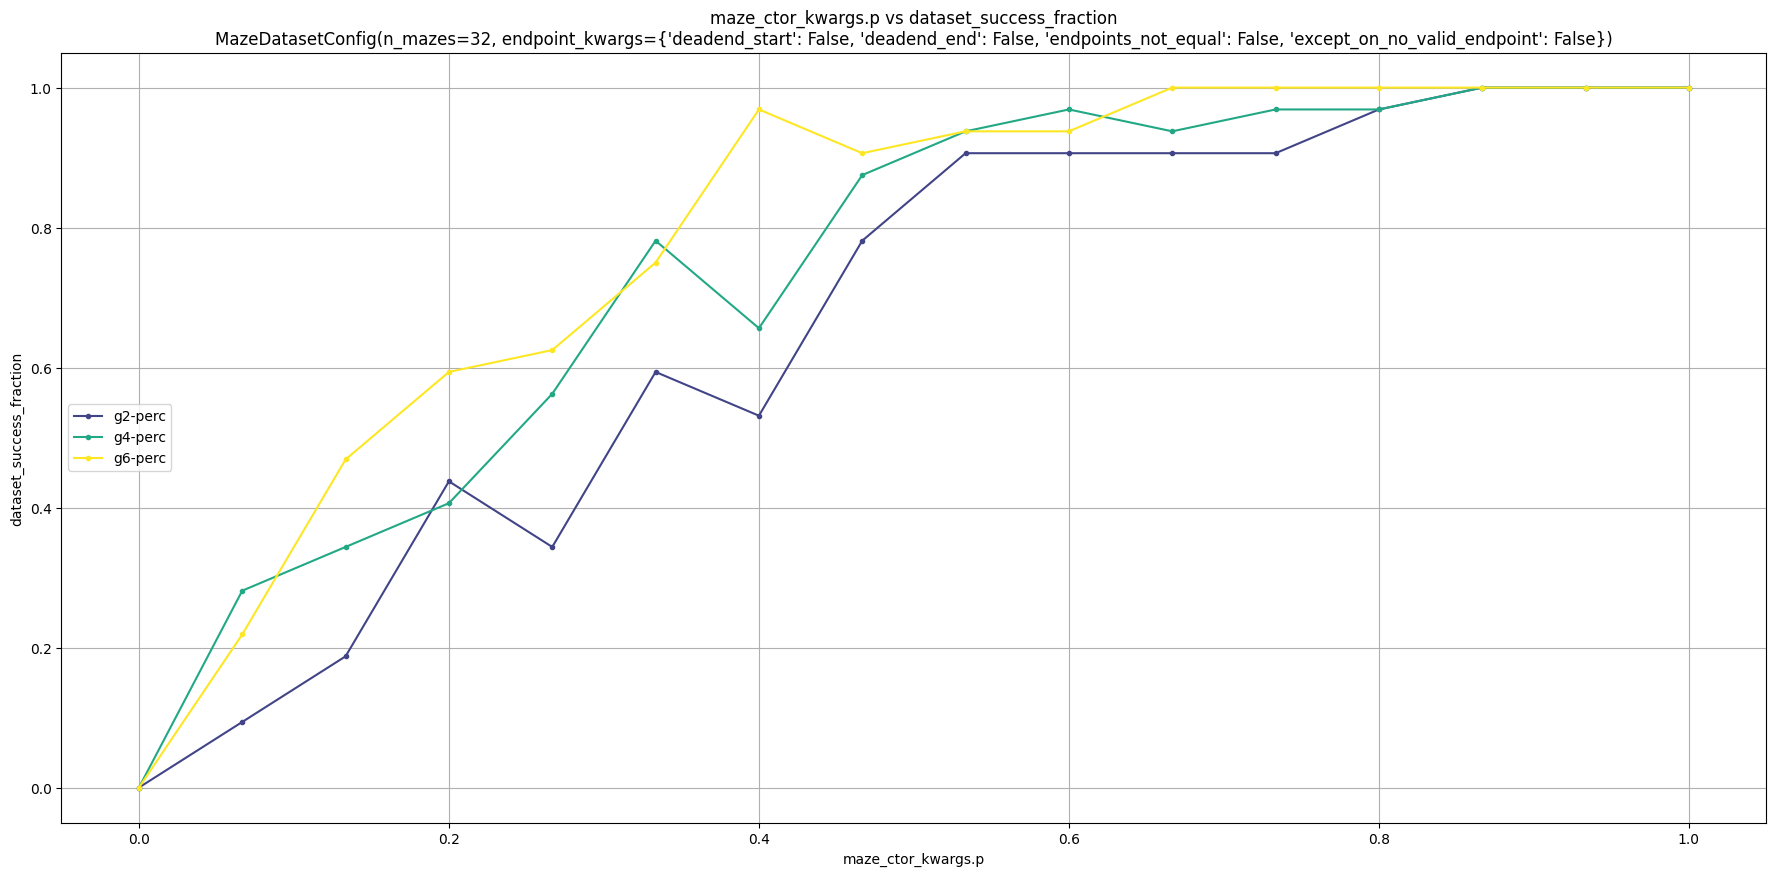

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [3]:
path = Path("../tests/_temp/dataset_frac_sweep/results_small.zanj")
results.save(path)
ZANJ().read(path).plot(cfg_keys=["n_mazes", "endpoint_kwargs"])

# sweep acrossall endpoint kwargs and generator funcs 

In [4]:
results_sweep: SweepResult = full_percolation_analysis(
	n_mazes=16,
	p_val_count=11,
	grid_sizes=[2, 4, 6],
	parallel=False,
	save_dir=Path("tests/_temp/dataset_frac_sweep"),
)

tqdm_allowed_kwargs = {'mininterval', 'nrows', 'smoothing', 'ascii', 'unit_scale', 'position', 'self', 'gui', 'unit', 'leave', 'ncols', 'miniters', 'initial', 'write_bytes', 'colour', 'lock_args', 'desc', 'total', 'disable', 'file', 'postfix', 'bar_format', 'delay', 'maxinterval', 'iterable', 'unit_divisor', 'dynamic_ncols'}
mapped_kwargs = {'total': 18, 'desc': 'Processing 18 items'}


Processing 18 items: 100%|██████████| 18/18 [00:05<00:00,  3.31it/s]


Saving results to tests/_temp/dataset_frac_sweep/result-n16-c18-p11.zanj


In [15]:
results_medium: SweepResult = SweepResult.read(
	"../docs/benchmarks/percolation_fractions/medium/result-n128-c42-p50.zanj",
	# "../docs/benchmarks/percolation_fractions/large/result-n256-c54-p100.zanj"
)

Saving plot to ../docs/paper/figures/ep/ep_any.pdf


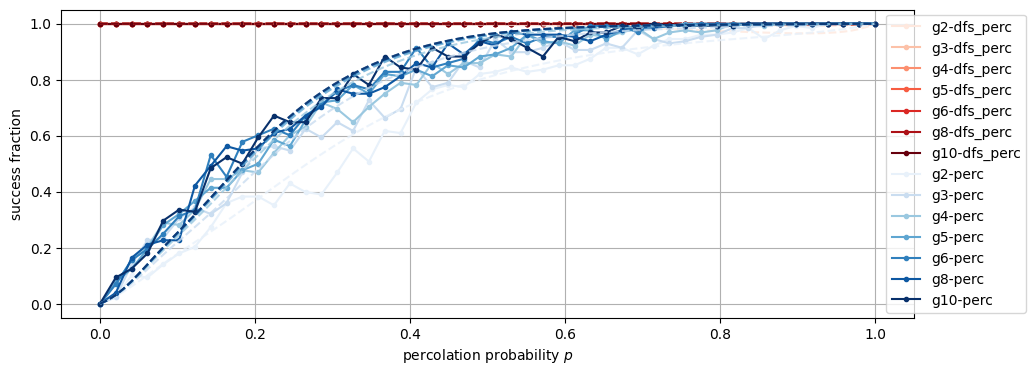

Saving plot to ../docs/paper/figures/ep/ep_deadends.pdf


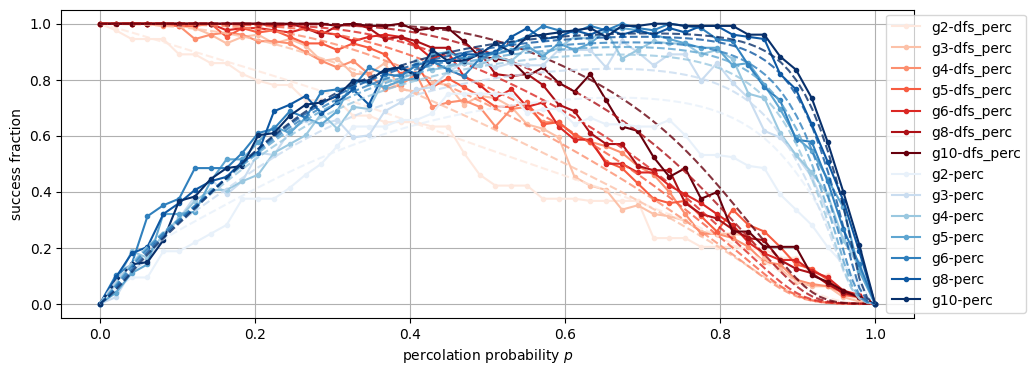

Saving plot to ../docs/paper/figures/ep/ep_deadends_unique.pdf


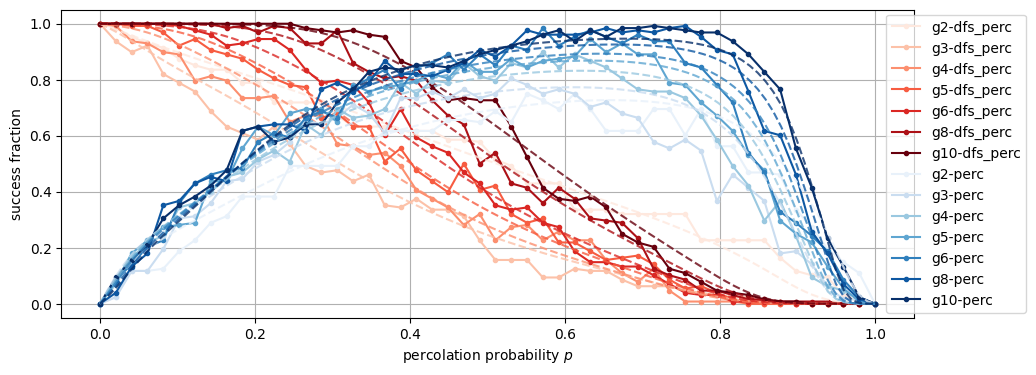

In [16]:
plot_grouped(
	results_medium,
	predict_fn=lambda x: x.success_fraction_estimate(),
	prediction_density=100,
	# for paper version
	figsize=(11, 4),
	save_fmt="pdf",
	save_dir=Path("../docs/paper/figures/ep"),
	minify_title=True,
	legend_kwargs=dict(loc="center right", ncol=1, bbox_to_anchor=(1.14, 0.5)),
	manual_titles=dict(
		x="percolation probability $p$",
		y="success fraction",
		title="",
	),
)

# perform a pysr regression on a dataset we load

In [ ]:
DATA_PATH_DIR: Path = Path("../docs/benchmarks/percolation_fractions/")
# DATA_PATH: str = DATA_PATH_DIR / "large/result-n256-c54-p100.zanj"
# DATA_PATH: str = DATA_PATH_DIR / "medium/result-n128-c42-p50.zanj"
DATA_PATH: str = DATA_PATH_DIR / "small/result-n64-c30-p25.zanj"
# DATA_PATH: str = DATA_PATH_DIR / "test/result-n16-c12-p16.zanj"

sweep_fit(
	DATA_PATH,
	Path("tests/_temp/fit_plots/"),
	niterations=3,
)

# interactive plots for figuring out `maze_dataset.math.soft_step()`

In [ ]:
# Run the interactive visualization if in a Jupyter notebook
if "__vsc_ipynb_file__" in globals():
	from maze_dataset.benchmark.sweep_fit import create_interactive_plot

	create_interactive_plot(True)

In [ ]:
cfg = MazeDatasetConfig(
	name="test",
	seed=3,
	grid_n=5,
	n_mazes=10,
	maze_ctor=LatticeMazeGenerators.gen_dfs_percolation,
	maze_ctor_kwargs=dict(p=0.7),
	endpoint_kwargs=dict(
		deadend_start=True,
		# deadend_end=True,
		endpoints_not_equal=True,
		except_on_no_valid_endpoint=False,
	),
)

print(f"{cfg.success_fraction_estimate() = }")
cfg_new = cfg.success_fraction_compensate()
print(f"{cfg_new.n_mazes = }")

In [ ]:
len(MazeDataset.from_config(cfg_new))